# Titanic Dataset
## Binary classification
Analyse the data and classify passengers will survive or not. 

### Data Dictionary


| Variable  | Definition | Key |
|-----------|------------|-----|
| survival  | Survival | 0 = No, 1 = Yes|
| pclass    | Ticket class| 1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|Sex|  |
|Age|Age in years|  |
|sibsp|# of siblings / spouses aboard the Titanic|   |
|parch|# of parents / children aboard the Titanic|   |
|ticket| Ticket number|  |	
|fare| Passenger fare|   |
|cabin| Cabin number|   |
|embarked| Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton| |


### Variable Notes

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sb
import logistic_regression as lgr # implemented logistic regression
from sklearn.linear_model import LogisticRegression as lgr2  # logistic regression from scikit learn
from sklearn.model_selection import train_test_split

plt.style.use('mycustomstyle')
%matplotlib inline

In [2]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

____

# Cleaning up the data for analysis

### 1. Dropping the obselete columns

In [3]:
# Pclass has identical information as Fare (higher Plcass will have higher fare). 
# Cabin is given to 1st class passenger and may not impact the outcome 
# PassengerId has info for Name
# Ticket number will not likely affect the survival chances
# Emabrking port should also not impact the survival chances but we will keep it for now to test and discard.
train1 = train.drop(['Name','Ticket','Cabin'], axis=1)
test1 = test.drop(['Name','Ticket','Cabin'], axis=1)


### 2. Null values

In [4]:
# Number of null values in train data
# From: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python
train1.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

#### 2.1 Age variable

C:\Users\login\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\login\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Median age =  28.0 years ; Mode age =  24.0 years


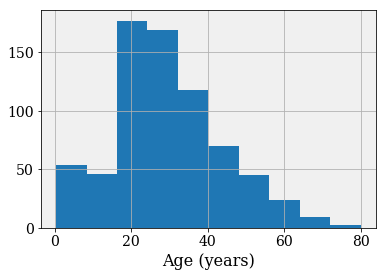

In [5]:
# Visualizing the Age variable
plt.hist(train1['Age'])
plt.xlabel('Age (years)')
median_age = np.nanmedian(train1['Age'])
print('Median age = ',median_age,'years', '; Mode age = ',statistics.mode(train1['Age']),'years')

In [6]:
# Use median age to fill null values
train1['Age'] =train1['Age'].fillna(median_age)
test1['Age'] =test1['Age'].fillna(median_age)

#### 2.2 Embarked variable

S    644
C    168
Q     77
Name: Embarked, dtype: int64


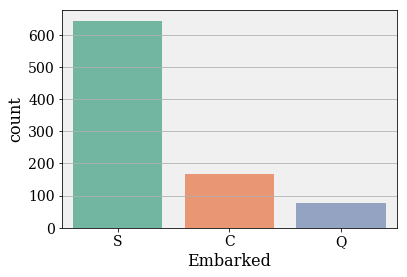

In [7]:
# Visualizing Embarked variable
# From: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python
sb.countplot(x ='Embarked',data =train1, palette ='Set2')
print(train1.Embarked.value_counts())

# Most people embarked from Southampton port. So we will use this for null values.

In [8]:
# Filling null values for Embarked
train1.Embarked.fillna(train1.Embarked.value_counts().idxmax(),inplace =True)
test1.Embarked.fillna(train1.Embarked.value_counts().idxmax(),inplace =True)

In [9]:
# Retesting the null values
train1.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

### 3. Changing Categorical variables to dummy variables for the analysis

In [10]:
# Converting categorical columns to dummy variables
# DO NOT RERUN IF PREVIOUS CELLS HAVE NOT BEEN RERUN

train1['travelAlone'] =  np.multiply(train1['Parch'] ==0,train1['SibSp'] ==0) *1
test1['travelAlone'] =  np.multiply(test1['Parch'] ==0,test1['SibSp'] ==0) *1

train1['gender'] =  (train1.Sex =='male')*1
test1['gender'] =  (test1.Sex =='male')*1

train1 = pd.get_dummies(train1,columns=['Embarked','Pclass'])
test1 = pd.get_dummies(test1, columns = ['Embarked','Pclass'])

# Drop the previous columns
train1.drop(['Sex','SibSp','Parch'],axis=1, inplace =True)
test1.drop(['Sex','SibSp','Parch'],axis=1, inplace =True)

In [11]:
train1.head()

,PassengerId,Survived,Age,Fare,travelAlone,gender,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,1,0,22.0,7.2500,0,1,0,0,1,0,0,1
1,2,1,38.0,71.2833,0,0,1,0,0,1,0,0
2,3,1,26.0,7.9250,1,0,0,0,1,0,0,1
3,4,1,35.0,53.1000,0,0,0,0,1,1,0,0
4,5,0,35.0,8.0500,1,1,0,0,1,0,0,1


---------

# Understanding the data

## Plotting the histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F3FB3E8588>,
      dtype=object)

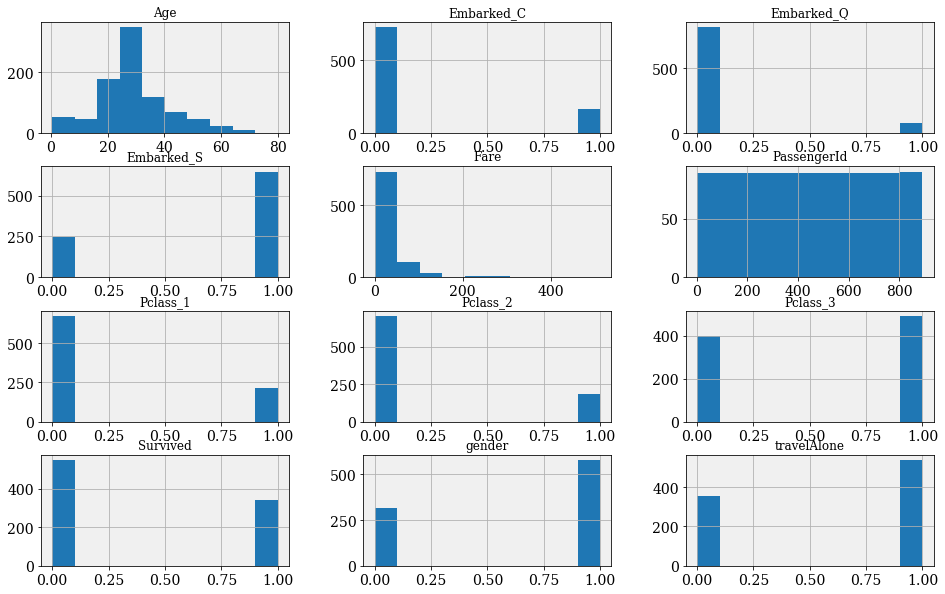

In [12]:
train1.hist(figsize=(16,10))

Doesn't help much!

## Try again

### 1. Age

Analysis from: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

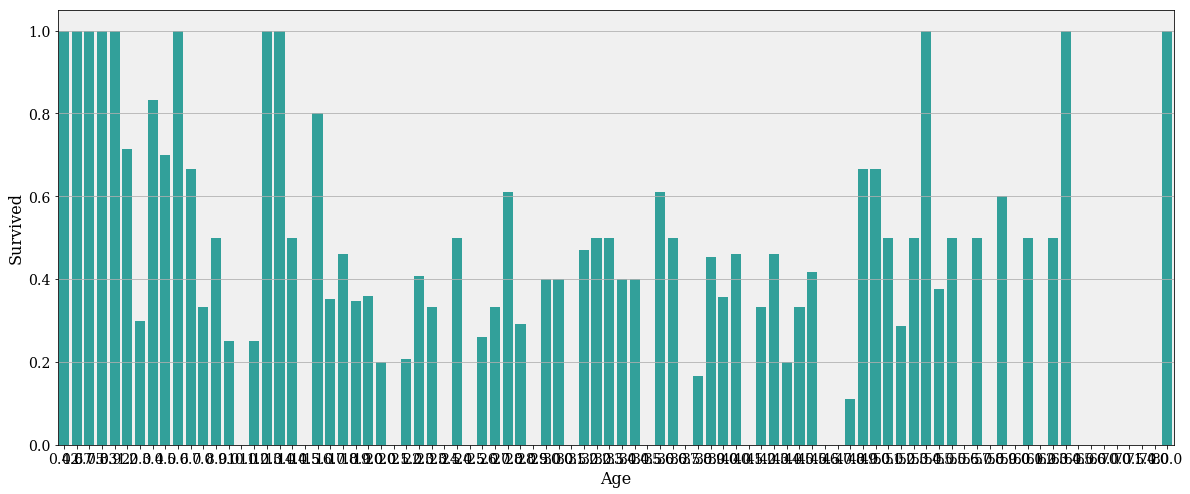

In [12]:
# Age consideration
plt.figure(figsize=(20,8))
avg_survival_byage = train1[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
g = sb.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
plt.show()

In [13]:
minor_survival_rate = ((train1.Age<16)*train1.Survived).sum()/(train1.Age<16).sum()
print('The minor (=Age<16) survival rate is:', round(minor_survival_rate*100,1),'%')

nonminor_survival_rate = ((train1.Age>16)*train1.Survived).sum()/(train1.Age>16).sum()
print('The non-minor (=Age>16) survival rate is:', round(nonminor_survival_rate*100,1),'%')

print('Overall survival rate is:', round(100*train1.Survived.sum()/train1.Survived.count(),1),'%')

The minor (=Age<16) survival rate is: 59.0 %
The non-minor (=Age>16) survival rate is: 36.3 %
Overall survival rate is: 38.4 %


 Given the survival rate at younger age, it would be worthwhile to include a variable 'isMinor' with age <16. It pays to analyse the data before doing the modelling.

In [14]:
train1['isMinor'] = (train1['Age']<16.0)*1
test1['isMinor'] = (test1['Age']<16.0)*1
train1.head()

,PassengerId,Survived,Age,Fare,travelAlone,gender,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,isMinor
0,1,0,22.0,7.2500,0,1,0,0,1,0,0,1,0
1,2,1,38.0,71.2833,0,0,1,0,0,1,0,0,0
2,3,1,26.0,7.9250,1,0,0,0,1,0,0,1,0
3,4,1,35.0,53.1000,0,0,0,0,1,1,0,0,0
4,5,0,35.0,8.0500,1,1,0,0,1,0,0,1,0


## 2. Fare

### 2.1 Survival rate as function of Fare

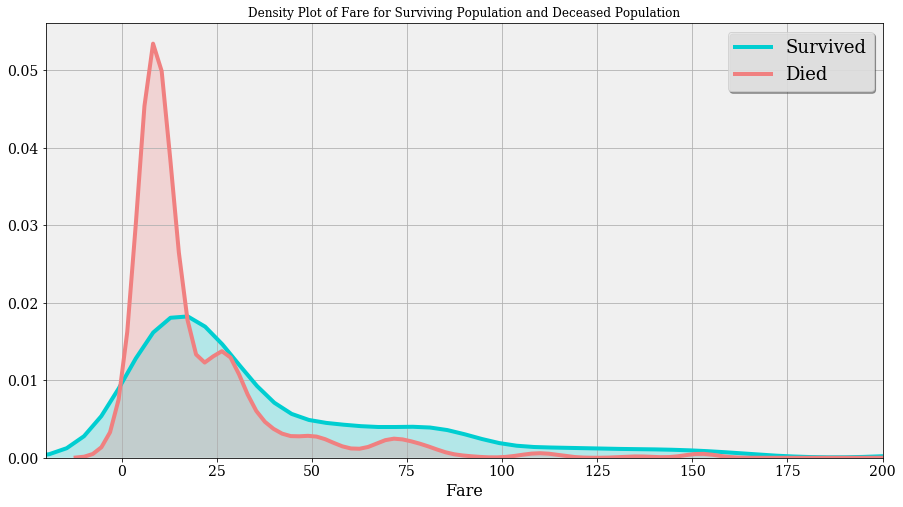

In [15]:
plt.figure(figsize=(15,8))
ax = sb.kdeplot(train1["Fare"][train1.Survived == 1], color="darkturquoise", shade=True)
sb.kdeplot(train1["Fare"][train1.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

### 2.2 Pclass as function of Fare

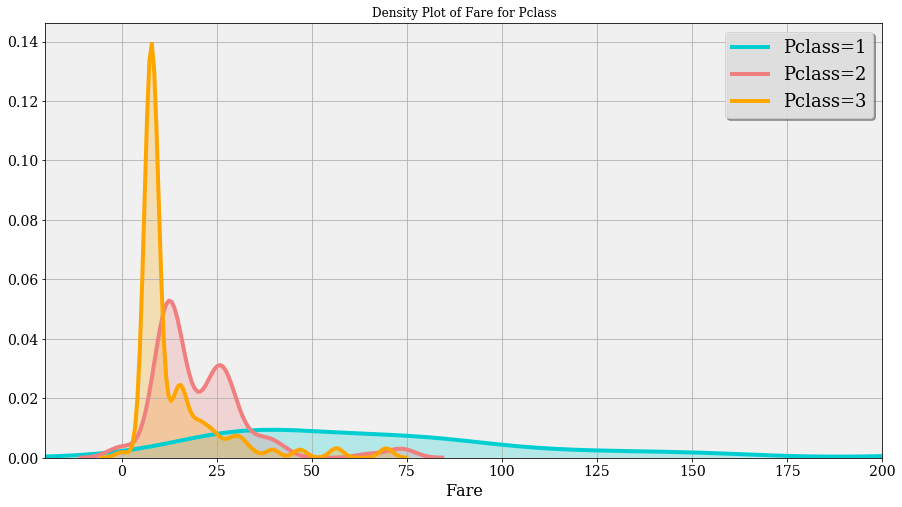

In [16]:
plt.figure(figsize=(15,8))
ax = sb.kdeplot(train1["Fare"][train1.Pclass_1 == 1], color="darkturquoise", shade=True)
sb.kdeplot(train1["Fare"][train1.Pclass_2 == 1], color="lightcoral", shade=True)
sb.kdeplot(train1["Fare"][train1.Pclass_3 == 1], color="orange", shade=True)

plt.legend(['Pclass=1', 'Pclass=2','Pclass=3'])
plt.title('Density Plot of Fare for Pclass')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

One would have assumed that different passenger class would have different fare bands but apparently, that's not the case. While the Pclass=3 has lowest fare mode, it certainly has some high fares. Pclass=1 distribution is quite evenly distributed across the fare range. It make sense to keep this variable along with Pclass.

### 3. Passenger Class

Same as before

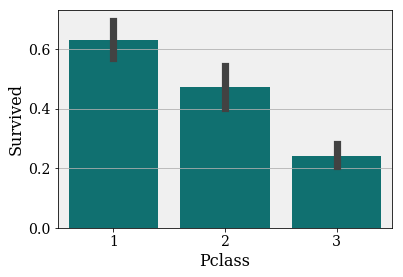

In [17]:
sb.barplot('Pclass','Survived',data =train,color ='teal')
plt.show()

### 4. Embarked Port

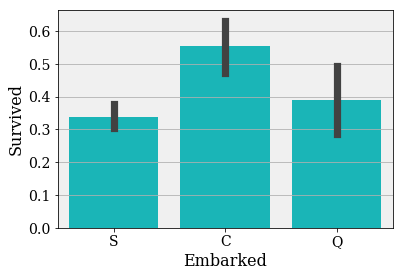

In [18]:
sb.barplot('Embarked','Survived',data=train, color= 'darkturquoise')
plt.show()

 This shows the people who boarded from Cherbroug, France had higher survival rate

In [28]:
Embark_C_Pclass_1 = np.multiply(train1["Pclass_1"],train1['Embarked_C']).sum()
Embark_C_Pclass_2 = np.multiply(train1["Pclass_2"],train1['Embarked_C']).sum()
Embark_C_Pclass_3 = np.multiply(train1["Pclass_3"],train1['Embarked_C']).sum()
print('Passenger class for people embarked at Cherbroug')
print('Pclass=1: ',Embark_C_Pclass_1, 'passengers, ', int(100* (Embark_C_Pclass_1/(Embark_C_Pclass_1+Embark_C_Pclass_2+Embark_C_Pclass_3))),'%')
print('Pclass=2: ', Embark_C_Pclass_2, 'passengers, ', int(100* (Embark_C_Pclass_2/(Embark_C_Pclass_1+Embark_C_Pclass_2+Embark_C_Pclass_3))),'%')
print('Pclass=3: ',Embark_C_Pclass_3, 'passengers, ', int(100* (Embark_C_Pclass_3/(Embark_C_Pclass_1+Embark_C_Pclass_2+Embark_C_Pclass_3))),'%')

Embark_S_Pclass_1 = np.multiply(train1["Pclass_1"],train1['Embarked_S']).sum()
Embark_S_Pclass_2 = np.multiply(train1["Pclass_2"],train1['Embarked_S']).sum()
Embark_S_Pclass_3 = np.multiply(train1["Pclass_3"],train1['Embarked_S']).sum()
print('Passenger class for people embarked at Southampton')
print('Pclass=1: ',Embark_S_Pclass_1, 'passengers, ', int(100* (Embark_S_Pclass_1/(Embark_S_Pclass_1+Embark_S_Pclass_2+Embark_S_Pclass_3))),'%')
print('Pclass=2: ', Embark_S_Pclass_2, 'passengers, ', int(100* (Embark_S_Pclass_2/(Embark_S_Pclass_1+Embark_S_Pclass_2+Embark_S_Pclass_3))),'%')
print('Pclass=3: ',Embark_S_Pclass_3, 'passengers, ', int(100* (Embark_S_Pclass_3/(Embark_S_Pclass_1+Embark_S_Pclass_2+Embark_S_Pclass_3))),'%')

Embark_Q_Pclass_1 = np.multiply(train1["Pclass_1"],train1['Embarked_Q']).sum()
Embark_Q_Pclass_2 = np.multiply(train1["Pclass_2"],train1['Embarked_Q']).sum()
Embark_Q_Pclass_3 = np.multiply(train1["Pclass_3"],train1['Embarked_Q']).sum()
print('Passenger class for people embarked at Q')
print('Pclass=1: ',Embark_Q_Pclass_1, 'passengers, ', int(100* (Embark_Q_Pclass_1/(Embark_Q_Pclass_1+Embark_Q_Pclass_2+Embark_Q_Pclass_3))),'%')
print('Pclass=2: ', Embark_Q_Pclass_2, 'passengers, ', int(100* (Embark_Q_Pclass_2/(Embark_Q_Pclass_1+Embark_Q_Pclass_2+Embark_Q_Pclass_3))),'%')
print('Pclass=3: ',Embark_Q_Pclass_3, 'passengers, ', int(100* (Embark_Q_Pclass_3/(Embark_Q_Pclass_1+Embark_Q_Pclass_2+Embark_Q_Pclass_3))),'%')

Passenger class for people embarked at Cherbroug
Pclass=1:  85 passengers,  50 %
Pclass=2:  17 passengers,  10 %
Pclass=3:  66 passengers,  39 %
Passenger class for people embarked at Southampton
Pclass=1:  129 passengers,  19 %
Pclass=2:  164 passengers,  25 %
Pclass=3:  353 passengers,  54 %
Passenger class for people embarked at Q
Pclass=1:  2 passengers,  2 %
Pclass=2:  3 passengers,  3 %
Pclass=3:  72 passengers,  93 %


Majority of people who embarked in Cherbroug were in Passenger class 1

In [24]:
Survival_Embark_C_Pclass_1 = np.multiply(np.multiply(train1["Pclass_1"],train1['Embarked_C']),train1.Survived).sum()
Survival_Embark_C_Pclass_2 = np.multiply(np.multiply(train1["Pclass_2"],train1['Embarked_C']),train1.Survived).sum()
Survival_Embark_C_Pclass_3 = np.multiply(np.multiply(train1["Pclass_3"],train1['Embarked_C']),train1.Survived).sum()

print('Survival rate for people embarked at Cherbroug as per the Passenger class')
print(Survival_Embark_C_Pclass_1,'people survived in Pclass=1 out of ',Embark_C_Pclass_1, 'passengers, ', 100*Survival_Embark_C_Pclass_1/Embark_C_Pclass_1)
print(Survival_Embark_C_Pclass_2,'people survived in Pclass=2 out of ',Embark_C_Pclass_2, 'passengers, ', 100*Survival_Embark_C_Pclass_2/Embark_C_Pclass_2)
print(Survival_Embark_C_Pclass_3,'people survived in Pclass=3 out of ',Embark_C_Pclass_3, 'passengers, ', 100*Survival_Embark_C_Pclass_3/Embark_C_Pclass_3)


Survival_Embark_S_Pclass_1 = np.multiply(np.multiply(train1["Pclass_1"],train1['Embarked_S']),train1.Survived).sum()
Survival_Embark_S_Pclass_2 = np.multiply(np.multiply(train1["Pclass_2"],train1['Embarked_S']),train1.Survived).sum()
Survival_Embark_S_Pclass_3 = np.multiply(np.multiply(train1["Pclass_3"],train1['Embarked_S']),train1.Survived).sum()

print('Survival rate for people embarked at Chouthampton as per the Passenger class')
print(Survival_Embark_S_Pclass_1,'people survived in Pclass=1 out of ',Embark_S_Pclass_1, 'passengers, ', 100*Survival_Embark_S_Pclass_1/Embark_S_Pclass_1)
print(Survival_Embark_S_Pclass_2,'people survived in Pclass=2 out of ',Embark_S_Pclass_2, 'passengers, ', 100*Survival_Embark_S_Pclass_2/Embark_S_Pclass_2)
print(Survival_Embark_S_Pclass_3,'people survived in Pclass=3 out of ',Embark_S_Pclass_3, 'passengers, ', 100*Survival_Embark_S_Pclass_3/Embark_S_Pclass_3)

Survival rate for people embarked at Cherbroug as per the Passenger class
59 people survived in Pclass=1 out of  85 passengers,  69.41176470588235
9 people survived in Pclass=2 out of  17 passengers,  52.94117647058823
25 people survived in Pclass=3 out of  66 passengers,  37.878787878787875
Survival rate for people embarked at Chouthampton as per the Passenger class
76 people survived in Pclass=1 out of  129 passengers,  58.91472868217054
76 people survived in Pclass=2 out of  164 passengers,  46.34146341463415
67 people survived in Pclass=3 out of  353 passengers,  18.980169971671387


### 5. Travelling alone

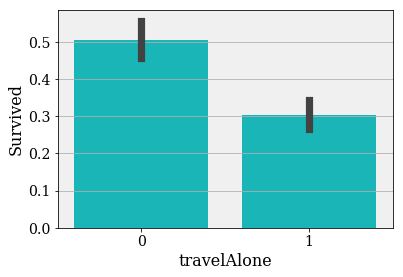

In [22]:
sb.barplot('travelAlone','Survived',data=train1, color= 'darkturquoise')
plt.show()

People who travelled alone had a higher chance of survival

### 6. Gender

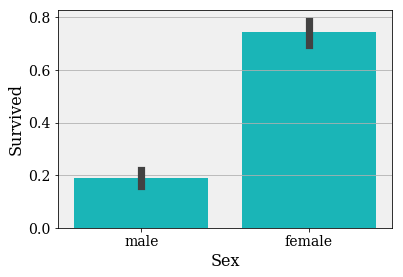

In [23]:
sb.barplot('Sex','Survived',data=train, color= 'darkturquoise')
plt.show()

Higher chance of survival for female 

--------

# Classifications

## 1. Logistic Regression
### 1.1 Implemented Logistic Regression

<font color ='red'>
**Check how normalizing Age and Fare will impact the logistic regression results** 
</fontcolor>

In [29]:
# import implemented logistic regression
train_X = train1.iloc[:,2:]
test_X = test1.iloc[:,1:]
train_Y = train1.iloc[:,1:2]
# t = float(np.sum(train_Y.T,axis=1))
# train_X =train_X.T
# test_X =test_X.T
# train_Y = train_Y.T

# train_Y = np.array(train_Y)
# test1_Y = lgr.predict(df['w'],df['b'],test_X) 
# train_Y

In [30]:
n =100
model ={}
for i in range(n):
    X_train, X_CV, y_train, y_CV = train_test_split(train_X, train_Y,test_size=0.1)
    print('Iteration number: ', i, 'out of ',n)
    model[i] = lgr.model(X_train.T,np.array(y_train.T),  X_CV.T, np.array(y_CV.T), num_iterations = 25000, learning_rate = 0.005, print_cost = False)
    
# plt.plot(df['costs'])
# plt.ylabel('Cost')
# plt.xlabel('# of iterations')


train accuracy: 80.52434456928839 %
test accuracy: 81.11111111111111 %
train accuracy: 81.27340823970037 %
test accuracy: 78.88888888888889 %
train accuracy: 81.14856429463171 %
test accuracy: 83.33333333333334 %
train accuracy: 80.39950062421973 %
test accuracy: 82.22222222222223 %
train accuracy: 81.27340823970037 %
test accuracy: 80.0 %
train accuracy: 80.64918851435705 %
test accuracy: 77.77777777777777 %
train accuracy: 79.7752808988764 %
test accuracy: 87.77777777777777 %
train accuracy: 80.14981273408239 %
test accuracy: 83.33333333333334 %
train accuracy: 81.77278401997503 %
test accuracy: 73.33333333333333 %
train accuracy: 80.39950062421973 %
test accuracy: 81.11111111111111 %
train accuracy: 80.52434456928839 %
test accuracy: 83.33333333333334 %
train accuracy: 80.27465667915106 %
test accuracy: 83.33333333333334 %
train accuracy: 82.02247191011236 %
test accuracy: 72.22222222222223 %
train accuracy: 81.02372034956305 %
test accuracy: 80.0 %
train accuracy: 80.02496878901374

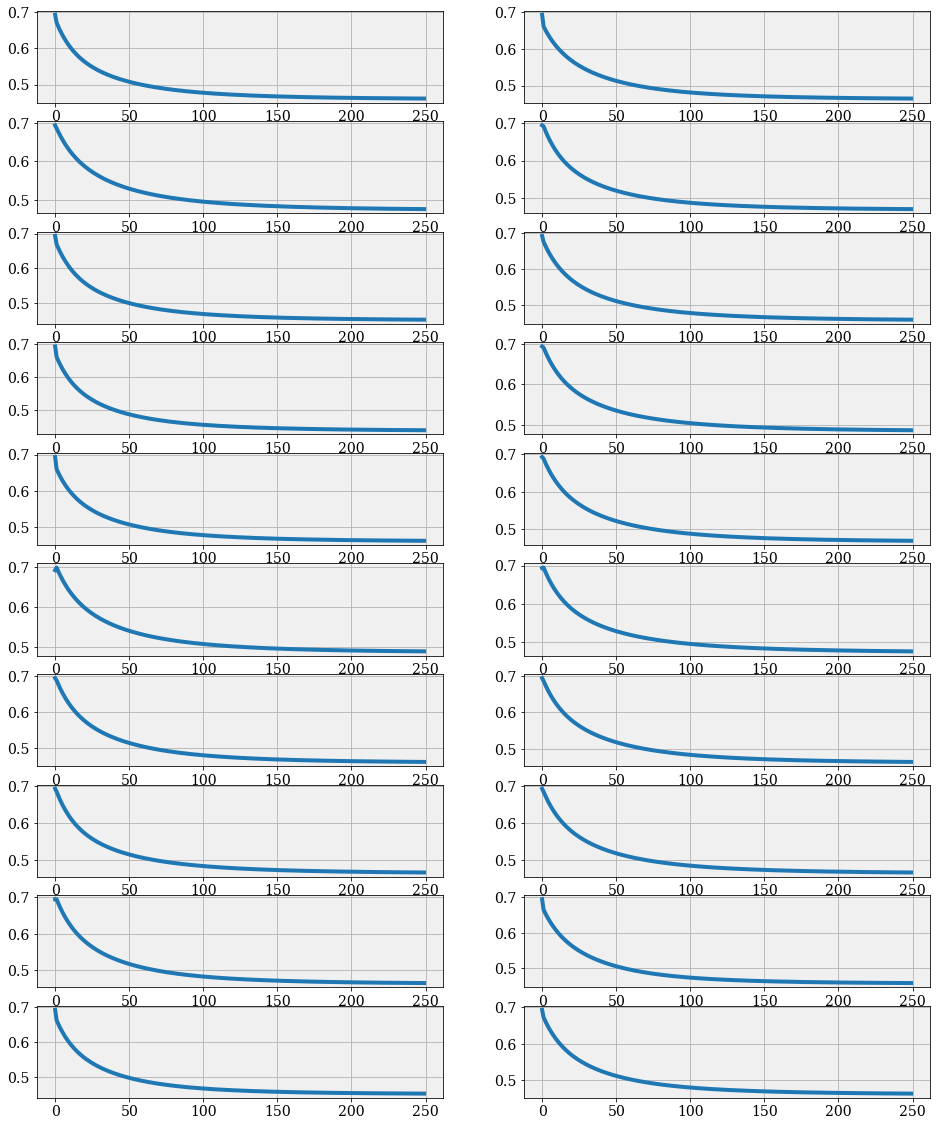

In [39]:
plt.figure(figsize=(16,20))
for i in range(n):
    plt.subplot(int(n/2),2,i+1)
    plt.plot(model[i]['costs'])

In [ ]:
# import implemented logistic regression
train_X = train1.iloc[:,2:]
train_X.Age = (train_X.Age - mean(train_X.Age))/std(train_X.Age)
test_X = test1.iloc[:,1:]
train_Y = train1.iloc[:,1:2]


Text(0.5, 1.0, 'Test Accouracy')

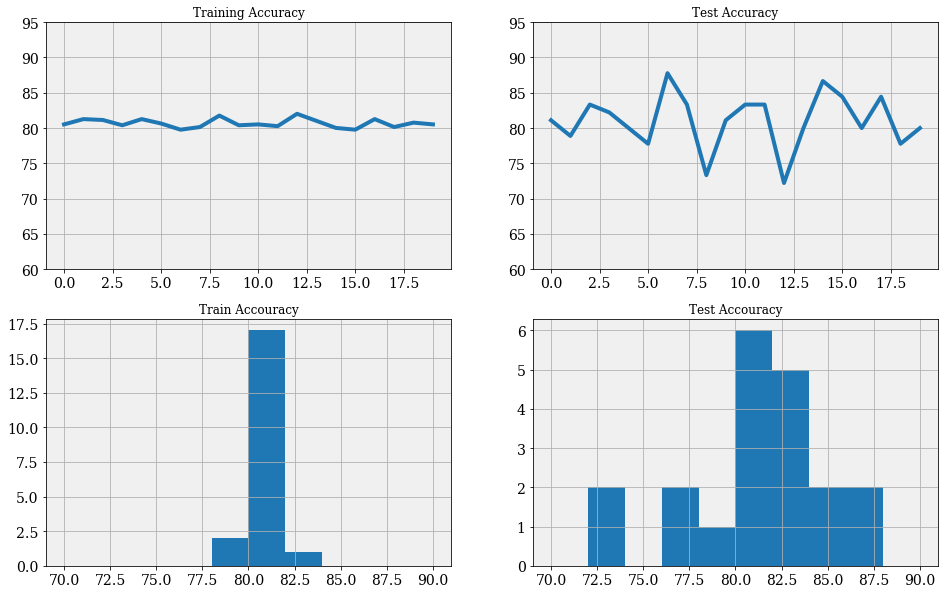

In [76]:
plt.figure(figsize=(16,10))
train_acc= []
test_acc = []
for i in range(n):
    train_acc.append(model[i]['train_accuracy'])
    test_acc.append(model[i]['test_accuracy'])

plt.subplot(2,2,1)
plt.plot(train_acc)
plt.ylim([60,95])
plt.title('Training Accuracy')

plt.subplot(2,2,2)
plt.plot(test_acc)
plt.ylim([60,95])
plt.title('Test Accuracy')

plt.subplot(2,2,3)
plt.hist(train_acc, range = [70,90])
plt.title('Train Accouracy')

plt.subplot(2,2,4)
plt.hist(test_acc,range = [70,90])
plt.title('Test Accouracy')

Age           -0.024733
Fare          -0.001762
travelAlone    0.362709
gender        -2.601624
Embarked_C     0.566747
Embarked_Q     0.382838
Embarked_S    -0.008186
Pclass_1       1.072311
Pclass_2       0.544344
Pclass_3      -0.675256
isMinor        0.745800
dtype: float64
Age            2.362586e-06
Fare           6.212835e-07
travelAlone    3.766043e-03
gender         3.662842e-03
Embarked_C     2.899018e-03
Embarked_Q     2.689145e-03
Embarked_S     2.053316e-03
Pclass_1       3.020003e-03
Pclass_2       2.485401e-03
Pclass_3       1.710698e-03
isMinor        5.736730e-03
dtype: float64


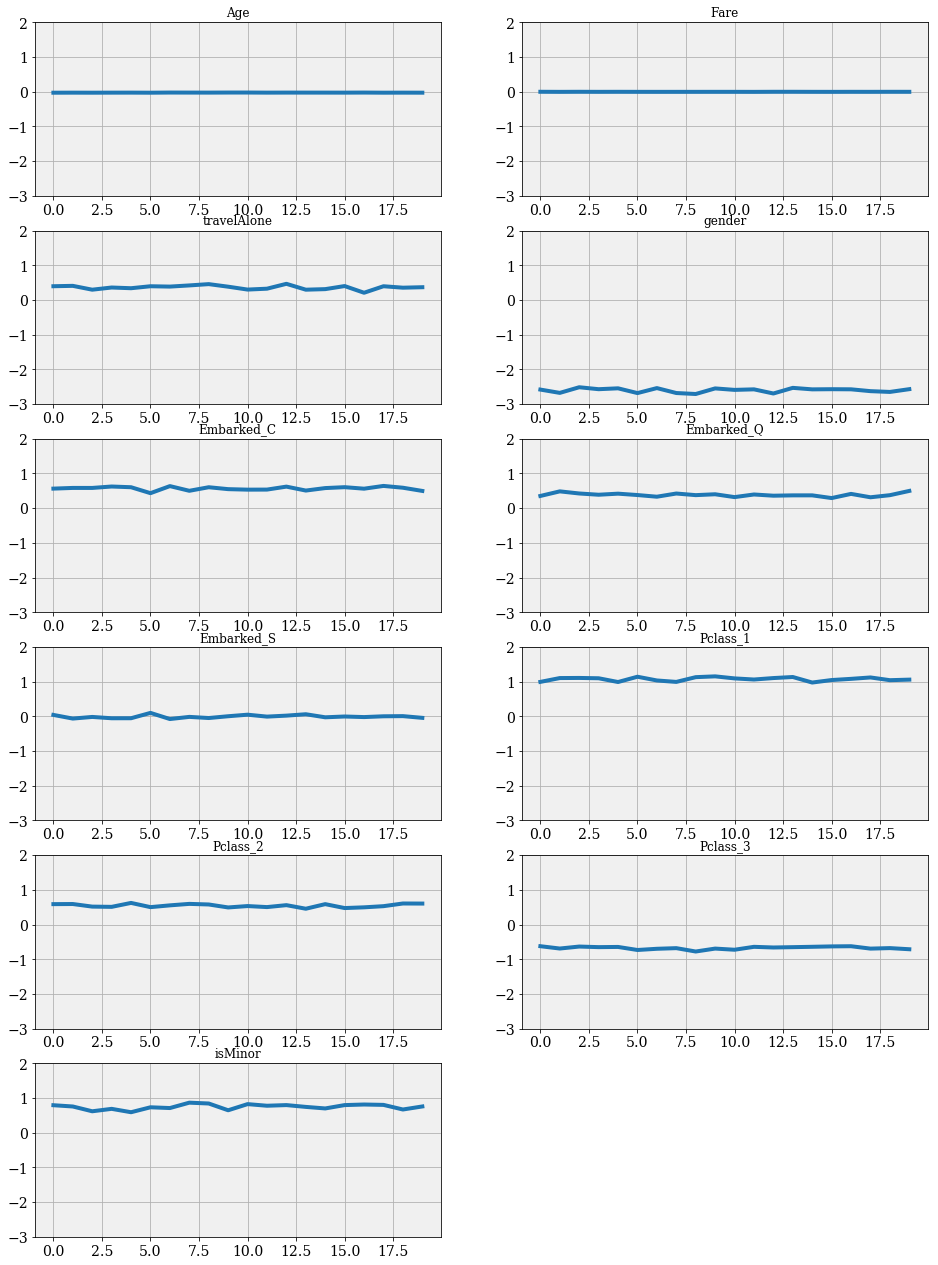

In [77]:
df_w = pd.DataFrame()
df_b = []
for i in range(n):
    df_b.append(model[i]['b'])
    data = pd.DataFrame.from_records(model[i]['w'])
    df_w = pd.concat([df_w,data],axis=1)

df_w = df_w.T
df_w.columns = X_train.columns
df_w = df_w.reset_index(drop=True)
print(df_w.mean())
print(df_w.var())
plt.figure(figsize =(16,30))
c =1
for i in df_w:
        plt.subplot(8,2,c)
        plt.plot(df_w[i])
        plt.title(i)
        plt.ylim([-3, 2])
        c+=1

# plt.figure(figsize =(16,30))
# c =1
# for i in df_w:
#         plt.subplot(8,2,c)
#         plt.hist(df_w[i], bins=10, range=[-3,2])
#         plt.title(i)
#         c+=1

In [ ]:
# import implemented logistic regression with normalized age and fare
train_X = train1.iloc[:,2:]
train_X.Age = (train_X.Age - mean(train_X.Age))/std(train_X.Age)
test_X = test1.iloc[:,1:]
train_Y = train1.iloc[:,1:2]


### 1.2 Scikit Logistic Regression

#### Feature Selection

Given an external estimator that assigns weights to features, recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

References: 
http://scikit-learn.org/stable/modules/feature_selection.html 

In [164]:
train_X = train1.iloc[:,2:]
test_X = test1.iloc[:,1:]
train_Y = train1.iloc[:,1:2]
train_Y = np.ravel(train_Y)

model2 = lgr2(tol = 1e-6,solver='lbfgs',max_iter =10000).fit(train_X,train_Y)
test2_Y = model2.predict(test_X)
print(model2.score(train_X,train_Y)*100)


79.2368125701459


#### 1.2.1 Parameter Testing: Solver

## 2. SVM

## 3. Random Forest

In [75]:
dat = pd.DataFrame(test2_Y,columns=['Survived'])
df = pd.concat([test,dat],axis=1)
# 
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [85]:
df2 = df[['PassengerId','Survived']]
df2.to_csv('Test_Y.csv')